In [1]:
import numpy as np
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
import msmtools
import scipy.linalg
import itertools
from scipy.integrate import odeint

import matplotlib.pyplot as plt
import networkx as nx

from local import Channel, cg_transition_matrix, kchannel_params, dndt

## Dimer system
### system structure
```
          ____full system_____
           /             \       
         channel 1  ~  channel 2  
            |               |       
(4 x gates - switch)  (4 x gates - switch)
```
- channels 1 and 2 are weakly coupled (cooperative coupling); if both switches are off, closed gate state is destabilized.

- each gate is coupled to switch of its channel; switch switches off individual gates.

- gates behave like Hodgkin-Huxley channel (details see previous notebook)

### scores
Two dependency scores are tested here: difference of transition matrix trace norms and transition matrix Frobenius norms.

## System setup
### basic channel

In [2]:
# set-up Hodgkin-Huxley channel with same parameters as in previous example
E_k = -75.
g_k = 24 #mmho/cm^2

V_clamp = 63

dt = 0.1
T = 15
time = np.arange(0, T, dt)

# initial condition
n_0 = 0

# Other parameters of the ODE
params = (V_clamp,)

ode_solution = odeint(dndt, n_0, time, params)

msmlag = 0.0001 # in seconds

alpha, beta, ss, tau = kchannel_params(V_clamp)
c = Channel(alpha*1000, beta*1000)

In [3]:
# transition matrix of HH-channel
Tm_singlet = c.transition_matrix_singlet(msmlag)
Tm_expandedstates = np.kron(np.kron(np.kron(Tm_singlet, Tm_singlet), Tm_singlet), Tm_singlet)

with np.printoptions(precision=4, suppress=True):
    print("single sub-system transition matrix:")
    print(Tm_singlet)

single sub-system transition matrix:
[[0.9483 0.0517]
 [0.0055 0.9945]]


### cooperative coupling
Modified transition matrix of HH channels for cases of two inactive deactivation switches.
This models a comparably weak cooperative coupling as the closed state is slightly destabilized.

In [4]:
Tm_singlet_coop = np.array([[0.8, 0.2], 
                            [0.0055, 0.9945]])
Tm_expandedstates_coop = np.kron(np.kron(np.kron(Tm_singlet_coop, Tm_singlet_coop), Tm_singlet_coop), Tm_singlet_coop)
msmtools.analysis.is_reversible(Tm_expandedstates_coop)

True

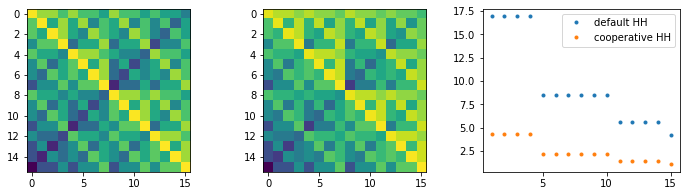

In [5]:
# compare regular HH to modified transition matrix (cooperative case)

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
ax[0].imshow(Tm_expandedstates, norm=plt.matplotlib.colors.LogNorm())
ax[1].imshow(Tm_expandedstates_coop, norm=plt.matplotlib.colors.LogNorm())
ax[2].plot(msmtools.analysis.timescales(Tm_expandedstates), '.', label='default HH')
ax[2].plot(msmtools.analysis.timescales(Tm_expandedstates_coop), '.', label='cooperative HH')
ax[2].legend()
# dynamics is faster in modified matrix

### deactivation switch
Matrix of switched gates, assembled by Kronecker product as gates are independent. The deactivation switch strongly destabilizes the open gate state.

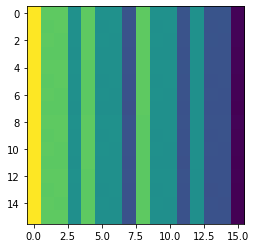

In [6]:
inactivetmat_singlet = np.array([[0.9483, 0.0517], 
                                 [.95, .05]])
inactivetmat_expanededstates = np.kron(np.kron(np.kron(inactivetmat_singlet, inactivetmat_singlet), inactivetmat_singlet), inactivetmat_singlet)
plt.imshow(inactivetmat_expanededstates, norm=plt.matplotlib.colors.LogNorm())

We assemble single channel transition matrix as a block matrix with probability switch_p to shift towards an inactive state. This matrix is only used for visualization purposes and to compare our estimates later.

True


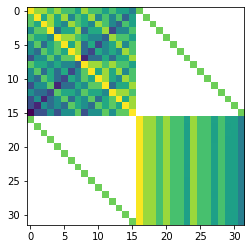

In [7]:
switch_p = .01
#during switching, system stays in same microstate
channel_tmat = np.block([[Tm_expandedstates * (1 - switch_p), switch_p * np.eye(16)],   # switch inactive -> inactive, switch inactive -> active
                         [switch_p * np.eye(16), (1 - switch_p) * inactivetmat_expanededstates]])  # switch active -> inactive, switch active -> active

print(msmtools.analysis.is_transition_matrix(channel_tmat))
plt.imshow(channel_tmat, norm=plt.matplotlib.colors.LogNorm())

### assemble full system transition matrix

In [8]:
def assemble_tmat(_lambda):
    """
    assembles full system as a block matrix.
    note: the assembled full system transition matrix does not have the indices 
    of a Kronecker product but the same entries.
    
    :param _lambda: float in [0, 1], coupling parameter
    
    :return:
    transition matrix of the full system
    """
    
    # compute linear mixture of transition matrices inactive and active (default)
    linear_mixture_inactiveactive = _lambda * inactivetmat_expanededstates + (1 - _lambda) * Tm_expandedstates
    assert msmtools.analysis.is_tmatrix(linear_mixture_inactiveactive)
    
    # define basic building blocks, each describing transition of deactivation switch (DG)
    DG_switching = switch_p * np.eye(16)
    DG_inact = Tm_expandedstates * (1 - switch_p)
    DG_act = (1 - switch_p) * linear_mixture_inactiveactive

    # describes cooperative state of two inactive deactivation switches
    DG_inact_extboost = Tm_expandedstates_coop * (1 - switch_p)

    # build transition matrices for dimer system for both deactivation switch transitions
    D1G00_D2G11 = np.kron(DG_inact, DG_act)
    D1G00_D2G10 = np.kron(DG_inact, DG_switching)
    D1G00_D2G01 = np.kron(DG_inact, DG_switching)
    D1G00_D2G00 = np.kron(DG_inact_extboost, DG_inact_extboost)
    D1G11_D2G11 = np.kron(DG_act, DG_act)
    D1G11_D2G10 = np.kron(DG_act, DG_switching)
    D1G11_D2G01 = np.kron(DG_act, DG_switching)
    D1G11_D2G00 = np.kron(DG_act, DG_inact)
    D1G10_D2G11 = np.kron(DG_switching, DG_act)
    D1G10_D2G10 = np.kron(DG_switching, DG_switching)
    D1G10_D2G01 = np.kron(DG_switching, DG_switching)
    D1G10_D2G00 = np.kron(DG_switching, DG_inact)
    D1G01_D2G11 = np.kron(DG_switching, DG_act)
    D1G01_D2G10 = np.kron(DG_switching, DG_switching)
    D1G01_D2G01 = np.kron(DG_switching, DG_switching)
    D1G01_D2G00 = np.kron(DG_switching, DG_inact)

    # assemble into a single transition matrix
    block = np.empty((1024, 1024))
    for D1Gstart, D1Gend in np.vstack(np.unravel_index(np.arange(4), (2, 2))).T:
        for D2Gstart, D2Gend in np.vstack(np.unravel_index(np.arange(4), (2, 2))).T:
            #print(f'{D1Gstart} -> {D1Gend}, {D2Gstart} -> {D2Gend}', np.ravel_multi_index((D1Gstart, D1Gend), (2, 2)))
            newstart = np.ravel_multi_index((D1Gstart, D2Gstart), (2, 2))
            newend = np.ravel_multi_index((D1Gend, D2Gend), (2, 2))
            block[256*newstart:256*(newstart+1), 256*newend:256*(newend+1)] = eval(f'D1G{D1Gstart}{D1Gend}_D2G{D2Gstart}{D2Gend}')
            
    assert msmtools.analysis.is_tmatrix(block)
    return block

## data generation
### choose parameters
Chosen large enough to ensure converged sampling.

In [9]:
tot_T = 1000000 # Steps
dt = 20 # skip time steps to ensure convergence w/ limited computer memory

n_independent_systems = 2 # dimer
n_subsys_switches = 5  # number of gates + desensitization switch
num_subsys = n_subsys_switches * n_independent_systems
lambdas = np.linspace(0, 1, 21)  # coupling parameter space

In [10]:
# sub-system indices of channel 1 (s1) and channel 2 (s2)
# note that due to assembly of subsystem transition matrices, 
# deactivation switch subsystems are indexed 0 and 1.
s1, s2 = (0, 2, 3, 4, 5), (1, 6, 7, 8, 9)
gates = (2, 3, 4, 5, 6, 7, 8, 9)

def is_extra_channel_edge(n1, n2):
    """
    distinguish if edge is within a channel or between two channels
    :param n1: int, sub-system 1 index
    :param n2: int, sub-system 2 index
    :return: 0 if within channel, 1 if between two channels
    """
    intra = (n1 in s1 and n2 in s1) or (n1 in s2 and n2 in s2)            
    if intra:
        return 0
    else:
        return 1

### define dependency score

In [11]:
def compute_dependency(tmat12, tmat1, tmat2, score='frobenius'):
    """
    compute dependency score between two systems
    :param tmat12: np.ndarray, transition matrix in joint space
    :param tmat1: np.ndarray, transition matrix in subsystem 1
    :param tmat2: np.ndarray, transition matrix in subsystem 2
    :param score: str, optional, matrix norm. one of frobenius, tracenorm.
    :return: float, dependency score
    """
    if score == 'frobenius':
        d = np.linalg.norm(tmat12, ord='fro')**2 - \
                    np.linalg.norm(tmat1, ord='fro')**2 * np.linalg.norm(tmat2, ord='fro')**2
    elif score == 'tracenorm':
        d = np.linalg.norm(tmat12, ord='nuc') - \
                    np.linalg.norm(tmat1, ord='nuc') * np.linalg.norm(tmat2, ord='nuc')
    else:
        raise NotImplementedError('score must be one of frobenius, tracenorm.')
        
    return abs(d)


### generate trajectories & compute dependency for different couplings

In [12]:
fronorms_dict, tracenorms_dict, cols = {}, {}, {}

for _lambda in tqdm_notebook(lambdas):
    fronorms_dict[_lambda] = []
    tracenorms_dict[_lambda] = []
    cols[_lambda] = []
    
    # assemble transition matrix
    block = assemble_tmat(_lambda)
    # choose time step T(n tau) = T(tau)^n
    _T = np.linalg.matrix_power(block, dt)
    
    # sample Markov chain, draw starting states from stationary distribution
    full_sys_traj = msmtools.generation.generate_traj(_T, tot_T, )
    
    # separate into sub-system trajectories
    independent_trajs = list(np.unravel_index(full_sys_traj, tuple((2 for _ in range(num_subsys)))))
    
    # compute single system transition matrices
    dmsm_tmat_dict = dict()
    dmsm_cmat_dict = dict()
    for n in range(num_subsys):
        dmsm_cmat_dict[n] = msmtools.estimation.cmatrix(independent_trajs[n], 1, sparse_return=False)
        dmsm_tmat_dict[n] = msmtools.estimation.tmatrix(dmsm_cmat_dict[n])
        
    # compute pairwise transition matrices and dependency scores
    for n1, n2 in itertools.combinations(range(num_subsys), 2):
        dmsm_cmat_dict[(n1, n2)] = msmtools.estimation.cmatrix(np.ravel_multi_index(np.vstack(np.array(independent_trajs)[[n1, n2]]), 
                                                             tuple((2 for _ in range(2)))), 
                                        1, sparse_return=False)
        dmsm_tmat_dict[(n1, n2)] = msmtools.estimation.tmatrix(dmsm_cmat_dict[(n1, n2)])
        
        # trace norm difference
        tracen = compute_dependency(dmsm_tmat_dict[(n1, n2)], 
                                    dmsm_tmat_dict[n1], 
                                    dmsm_tmat_dict[n2], 
                                    score='tracenorm')

        # frobenius norm difference
        fron = compute_dependency(dmsm_tmat_dict[(n1, n2)], 
                                  dmsm_tmat_dict[n1], 
                                  dmsm_tmat_dict[n2], 
                                  score='frobenius')
        
        fronorms_dict[_lambda].append(fron)
        tracenorms_dict[_lambda].append(tracen)
        
        # case decision for plotting
        cols[_lambda].append(is_extra_channel_edge(n1, n2))

### plot score as function of coupling

In [13]:
# some plot properties
_node_cols = ['#80aee7ff', '#e68082ff']
node_cols = [_node_cols[0] if n in s1 else _node_cols[1] for n in range(num_subsys)]

_c = (0., 0., 0.)
nodesize = 35
edge_cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list("uwe", [(*_c, 0.025), (*_c, 1)])
font = plt.matplotlib.font_manager.FontProperties(size=12)

rgb_int = 200
cmap_zero_noalpha = (rgb_int/256,rgb_int/256,rgb_int/256, 1)  # visual match between two figures (graph uses alpha)
colormap = np.array([edge_cmap(256), cmap_zero_noalpha])
colored_patches = [plt.matplotlib.patches.Patch(color=colormap[0], label='intra'),
                  plt.matplotlib.patches.Patch(color=colormap[1], label='extra')]

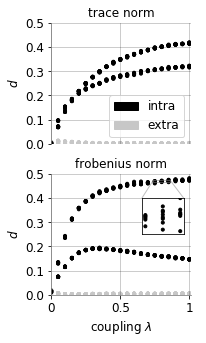

In [14]:
fig, ax = plt.subplots(2, 1, gridspec_kw={'hspace':.25}, figsize=(2.5, 5))
axin = ax[1].inset_axes([0.65, 0.5, 0.3, 0.3]) # [x0, y0, width, height]
axin.set_xlim(0.74, 0.86)
axin.set_ylim(0.465, 0.475)

for _lambda in lambdas:    
    ax[0].scatter([_lambda for _ in range(len(tracenorms_dict[_lambda]))], 
               tracenorms_dict[_lambda], c=colormap[np.array(cols[_lambda])], marker='.')
    
    for _ax in [ax[1], axin]:
        _ax.scatter([_lambda for _ in range(len(tracenorms_dict[_lambda]))], 
                   fronorms_dict[_lambda], c=colormap[np.array(cols[_lambda])], marker='.')

for n_ax, _ax in enumerate(ax.flat):
    
    #_ax.yaxis.tick_right()
    _ax.set_ylabel(r'$d$', fontproperties=font)
    #_ax.get_yaxis().set_label_position('right')
    _ax.spines['top'].set_color('none')
    
    if n_ax != 1:
        _ax.spines['bottom'].set_color('none')
        _ax.set_xticklabels([])
        _ax.tick_params(axis='x', colors='none')
        _ax.xaxis.set_tick_params(pad=0)
    else:
        _ax.spines['bottom'].set_color('grey')
        #_ax.xaxis.set_tick_params(pad=0)
        
    
    _ax.spines['left'].set_color('grey')
    _ax.spines['right'].set_color('none')

    grid = _ax.grid(True, color='k', alpha=.25, which='both', ls='-')

    _ax.set_xticks([0, 0.5, 1])
    _ax.set_xticklabels(['0', '0.5', '1'])

    for _t in list(_ax.yaxis.get_ticklabels()) + list(_ax.xaxis.get_ticklabels()):
        _t.set_font_properties(font)
    
    _ax.set_ylim(0, .5)
    _ax.set_xlim(lambdas[0], lambdas[-1]+0.01)
    
ax[1].set_xlabel(r'coupling $\lambda$', fontproperties=font)

ax[0].set_title('trace norm', fontproperties=font)
ax[1].set_title('frobenius norm', fontproperties=font)

axin.set_xticks([])
axin.set_yticks([])
ax[1].indicate_inset_zoom(axin)

fig.legend(loc=(.53, .6), handles=colored_patches, prop=font)

## graph analysis
Analyze strongest coupling case. Can we estimate the network from data?

In [15]:
# following code works on the last defined objects in this for loop, i.e. correspond to strongest coupling
assert _lambda == 1.

### assemble graph

In [16]:
# compute different scores and store in a networkx graph object
graph_fronorm = nx.Graph()
graph_trace = nx.Graph()

# for all pairs of subsystems, compute dependency scores with Frobenius and trace norm
for n1, n2 in itertools.combinations(range(num_subsys), 2):
    d = compute_dependency(dmsm_tmat_dict[(n1, n2)], 
                                  dmsm_tmat_dict[n1], 
                                  dmsm_tmat_dict[n2], 
                                  score='tracenorm')
    graph_trace.add_edge(n1, n2, weight=d)
    

    d = compute_dependency(dmsm_tmat_dict[(n1, n2)], 
                                  dmsm_tmat_dict[n1], 
                                  dmsm_tmat_dict[n2], 
                                  score='frobenius')
    graph_fronorm.add_edge(n1, n2, weight=d)

### plot graph

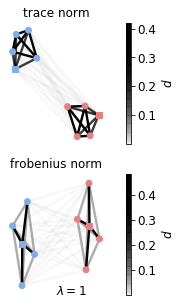

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(2.5, 5), gridspec_kw={'hspace':.25})
names = ['trace norm', 'frobenius norm']
for n_graph, graph in enumerate([graph_trace, graph_fronorm]):
    
    ax = axes[n_graph]
    # positions by Fruchterman-Reingold
    pos_dict = nx.spring_layout(graph, k=0.75 if n_graph == 0 else 0.4, seed=40, )
    ax.set_title(names[n_graph], fontproperties=font)

    weights = np.array(list(nx.get_edge_attributes(graph, 'weight').values()))

    # draw nodes representing gates (symbol o)
    nx.draw_networkx_nodes(graph, node_shape='o', 
                           nodelist=graph.subgraph([n for n in range(num_subsys) if n in gates]).nodes,
                           node_size=nodesize, 
                           pos=pos_dict, 
                           node_color=[node_cols[n] for n in range(num_subsys) if n in gates], 
                          ax=ax)
    
    # draw nodes representing deactivation switches (symbol square)
    nx.draw_networkx_nodes(graph, node_shape='s', 
                           nodelist=graph.subgraph([n for n in range(num_subsys) if n not in gates]).nodes,
                           node_size=nodesize, 
                           pos=pos_dict, 
                           node_color=[node_cols[n] for n in range(num_subsys) if n not in gates], 
                          ax=ax)
    # draw all edges
    pc = nx.draw_networkx_edges(graph, 
                     edge_color=weights, width=2.4,
                     pos=pos_dict, node_size=nodesize,
                     ax=ax,
                    )
    
    # define colormap
    pc.set_array(weights)
    pc.set_cmap(edge_cmap)

    cb = fig.colorbar(pc, ax=ax,
                      aspect=25, pad=.15)
    cb.set_label(r'$d$', fontproperties=font)
    cbarticks = cb.ax.yaxis.get_ticklabels()
    
    # set font properties
    for _t in list(cbarticks):
        _t.set_font_properties(font)
    ax.axis('off');
axes[1].text(0.5, 0, r'$\lambda = 1$', transform=axes[1].transAxes, fontproperties=font);

## modeling a single channel independently

Now that we have found the optimal partition, can we retrieve the model of one of the monomers, ignoring weak coupling between the channels?

In [18]:
# sub-system indexing ordered to match resulting matrices
subsystem_trajectory = np.ravel_multi_index(
    np.vstack(np.array(independent_trajs)[[0, 5, 4, 3, 2]]), tuple((2 for _ in range(n_subsys_switches)))
)

In [19]:
# note that this estimate is at a lagtime dt because trajectory was generated from T^dt
C = msmtools.estimation.cmatrix(subsystem_trajectory, 1, sparse_return=False)
T = msmtools.estimation.tmatrix(C)

### compare transition matrices & implied timescales

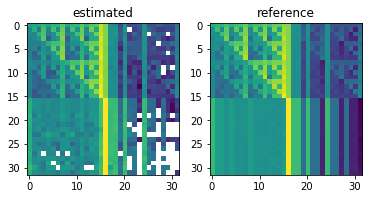

In [20]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(T, norm=plt.matplotlib.colors.LogNorm())
ax[0].set_title('estimated')
ax[1].imshow(np.linalg.matrix_power(channel_tmat, dt), norm=plt.matplotlib.colors.LogNorm())
ax[1].set_title('reference');

/storage/mi/thempel/anaconda3/envs/py37_oct19/lib/python3.7/site-packages/msmtools/analysis/dense/decomposition.py:540: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eigenvalues with non-zero imaginary part', ImaginaryEigenValueWarning)


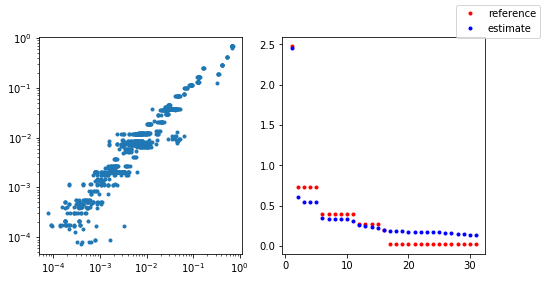

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].plot(T.flat, np.linalg.matrix_power(channel_tmat, dt).flat, '.')
ax[0].loglog()

its_ref = msmtools.analysis.timescales(np.linalg.matrix_power(channel_tmat, dt))
its_est = msmtools.analysis.timescales(T)

ax[1].plot(its_ref, 'r.', label='reference')
ax[1].plot(its_est, 'b.', label='estimate')
#ax[1].semilogy()
fig.legend()

Spectrum is well-approximated. As it does not incoporate the weak coupling between channels, it is only an approximation.